# Logistic regression model

## Fit a logistic regression model and make global and local explanations


Predict whether a student will dropout from their class.

The workflow is the following:

- Identify variables that are good predictors of the target.
- Identify and remove high multi-colinearity among the predictors.
- Fit a logistic model and assess the goodness of fit
- Ensure all features make statistically significant contributions to the outcome
- Interpret the coefficients (global interpretation)
- Evaluate a few observations individually (local interpretation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

from feature_engine.selection import SmartCorrelatedSelection

from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Load data

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

In [2]:
df = pd.read_csv('../../student_dropout_logit.csv')

print(df.shape)

df.head()

(4424, 102)


,Application order,Daytime/evening attendance\t,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,...,Nacionality_Italian,Nacionality_Cape Verdean,Nacionality_Turkish,Nacionality_Moldova (Republic of),Nacionality_Guinean,Nacionality_Colombian,Nacionality_German,Nacionality_Cuban,Nacionality_Russian,Nacionality_English
0,5,1,122.0,127.3,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,160.0,142.5,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,5,1,122.0,124.8,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,122.0,119.6,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,100.0,141.5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("dropout", axis=1),
    df["dropout"],
    test_size=0.2,
    random_state=1,
)

X_train.shape, X_test.shape

((3539, 101), (885, 101))

In [4]:
# Fraction of students who drops out.

y_train.mean(), y_test.mean()

(0.3241028539135349, 0.3096045197740113)

In [5]:
# scale the variables

scaler = MinMaxScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Variables

In [6]:
# Lists with numerical and categorical variables
# The categorical variables were one hot encoded
# into k-1 variables

cat_vars = [var for var in X_train.columns if "_" in var]
num_vars = [var for var in X_train.columns if var not in cat_vars]

len(cat_vars), len(num_vars)

(74, 27)

## Chi-square (categorical variables)

Find and remove categorical variables that are not good predictors of dropout. Use the chi-square test.

**Hint:** sklearn's chi-square function is not what you want. Use `scipy.stats`.

In [7]:
# Chi-square test to evaluate feature association
# to target.

chi_ls = []

for feature in cat_vars:
    
    # create contingency table
    c = pd.crosstab(y_train, X_train[feature])
    
    # chi_test
    p_value = stats.chi2_contingency(c)[1]
    chi_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

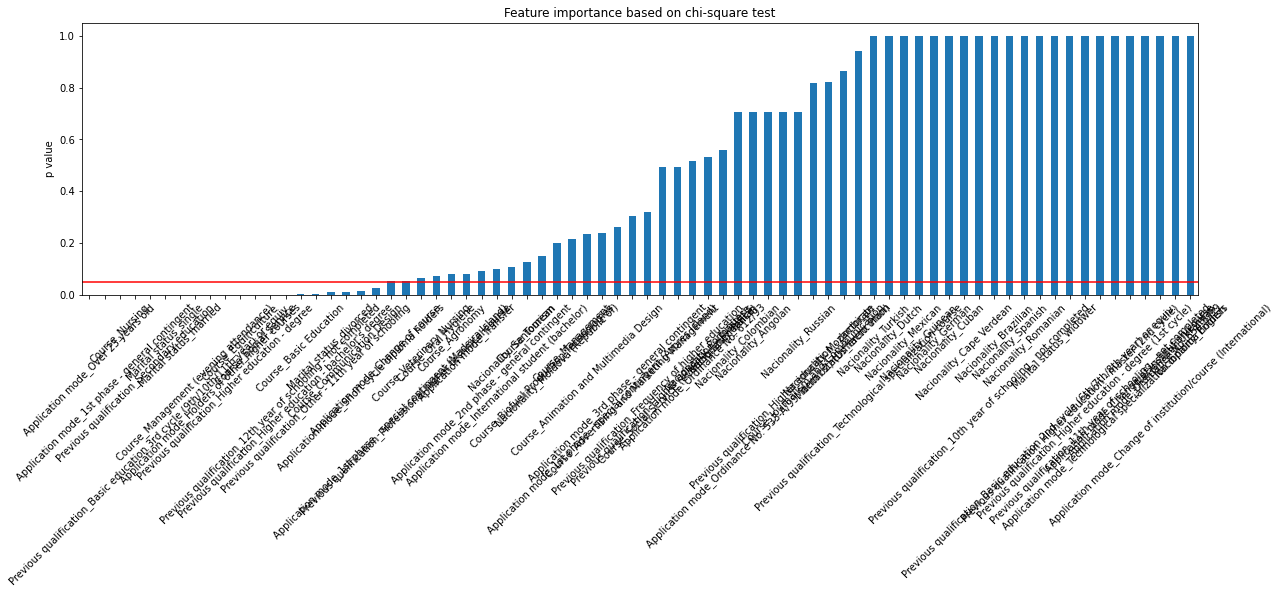

In [8]:
chi = pd.Series(chi_ls, index=cat_vars)

chi.sort_values(
    ascending=True).plot.bar(rot=45, figsize=(20, 5))

plt.axhline(y=0.05, color='r', linestyle='-')
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [9]:
# Remove variables that are NOT significant
# based on the chi-square test

remove = chi[chi > 0.05].index

X_train.drop(remove, axis=1, inplace=True)
X_test.drop(remove, axis=1, inplace=True)

In [10]:
# New data size

X_train.shape, X_test.shape

((3539, 47), (885, 47))

## Anova (numerical variables)

Find and remove numerical variables that are not good predictors of dropout. Use Anova or t-test.

**Hint:** The `f_classif` function from sklearn is what you want.

Text(0.5, 1.0, 'Feature importance based on anova')

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


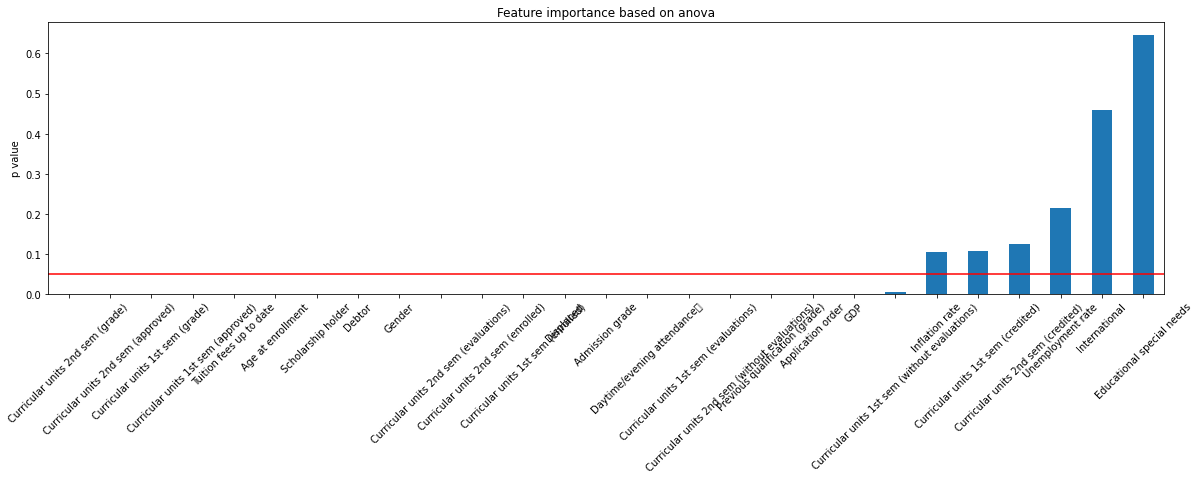

In [11]:
anova = f_classif(X_train[num_vars], y_train)

s = pd.Series(anova[1], index=num_vars)

s.sort_values(ascending=True).plot.bar(rot=45, figsize=(20, 5))

plt.axhline(y=0.05, color='r', linestyle='-')
plt.ylabel('p value')
plt.title('Feature importance based on anova')

In [12]:
# remove variables that are NOT significant
# based on the anova

remove = s[s > 0.05].index

X_train.drop(remove, axis=1, inplace=True)
X_test.drop(remove, axis=1, inplace=True)

In [13]:
X_train.shape, X_test.shape

((3539, 41), (885, 41))

In [14]:
# adjust variable types list

cat_vars = [var for var in X_train.columns if "_" in var]
num_vars = [var for var in X_train.columns if var not in cat_vars]

len(cat_vars), len(num_vars)

(20, 21)

## Correlation

Find and remove variables that are highly correlated to each other. Use 0.7 as threshold.

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


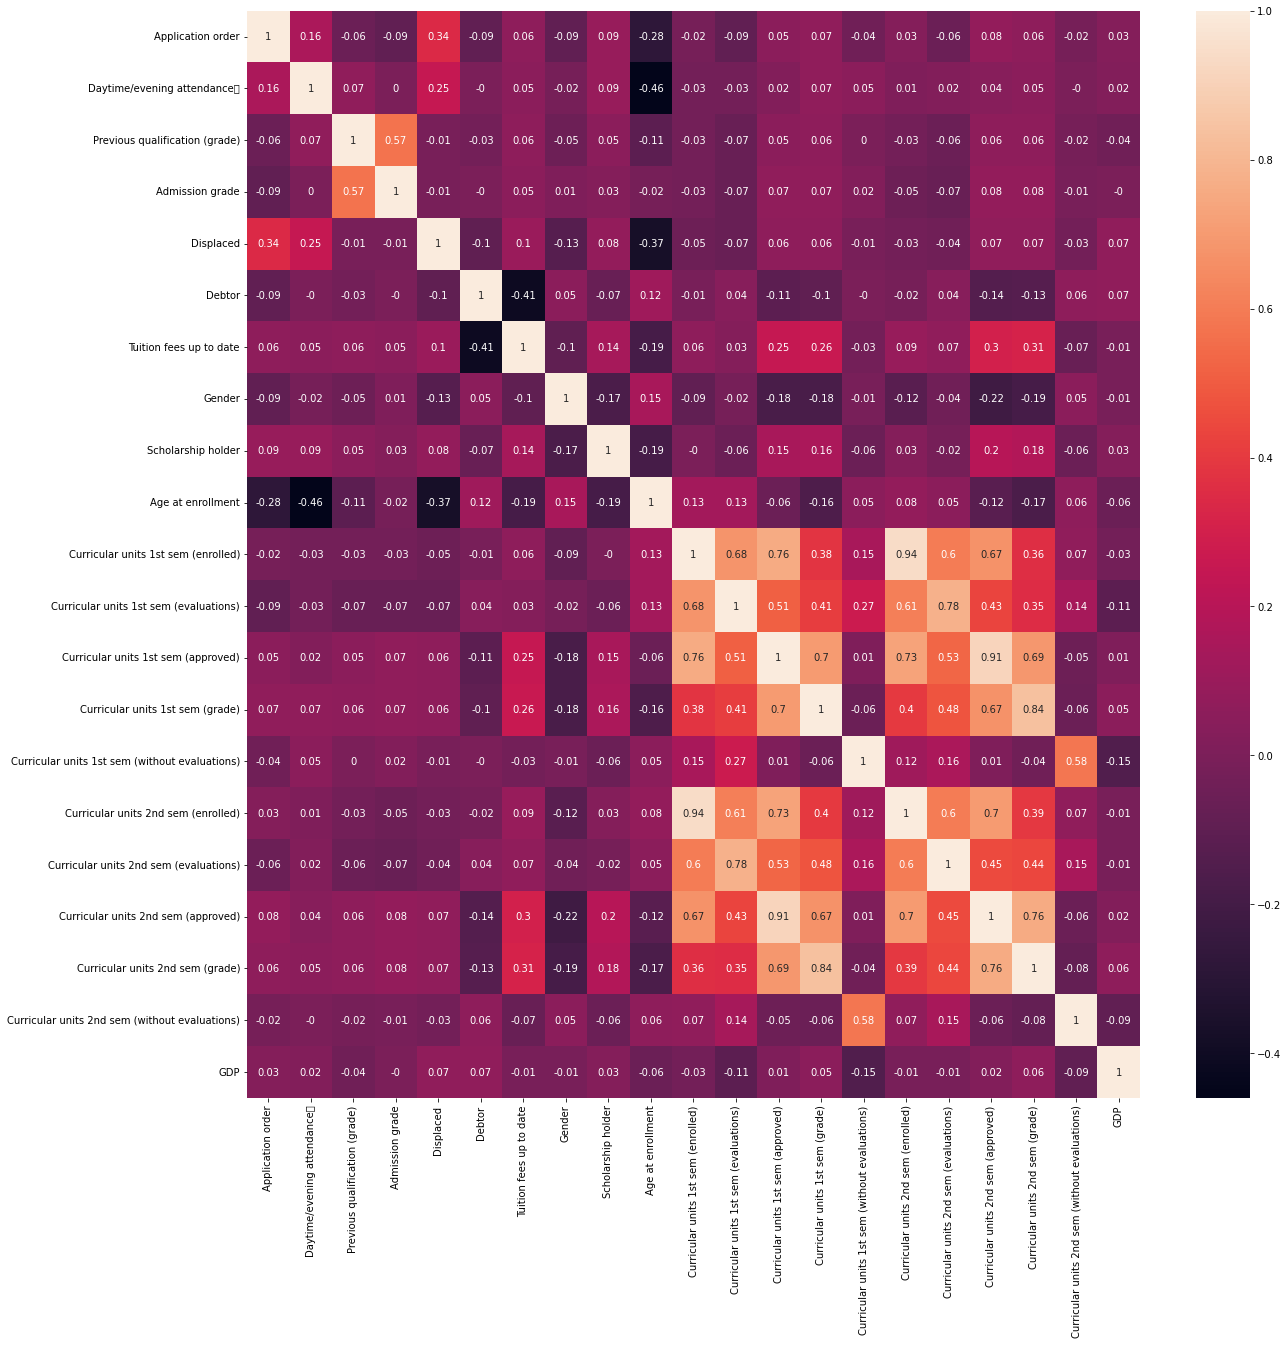

In [15]:
# We calculate the correlations using pandas corr()
# and we round the values to 2 decimals.
correlation_matrix = X_train[num_vars].corr().round(2)

# Plot the correlation matrix usng seaborn.
# We use annot = True to print the correlation values
# inside the squares.

figure = plt.figure(figsize=(20, 20))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

There are 2 or 3 variables that seem to be highly correlated. But the majority are not.

In [16]:
# I use this transformer from Feature-engine, but you may have as
# well done this manually.

sel = SmartCorrelatedSelection(
    variables=list(num_vars),
    threshold=0.7,
    selection_method='variance',
)

sel.fit(X_train, y_train)

# correlated variables
sel.correlated_feature_sets_

[{'Curricular units 1st sem (approved)',
  'Curricular units 1st sem (enrolled)',
  'Curricular units 2nd sem (enrolled)'},
 {'Curricular units 1st sem (evaluations)',
  'Curricular units 2nd sem (evaluations)'},
 {'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)'}]

In [17]:
# Retain variable with highest variability from
# each group

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((3539, 37), (885, 37))

## Logistic regression

Fit and evaluate a logistic regression model to predict dropout. 

Determine the accuracy of the model and its goodness of fit.

In [18]:
# fit model

# important to remove the penalty for unregularized regression.

logit = LogisticRegression(
    penalty=None,
    random_state=1,
    max_iter=1000,
)

logit.fit(X_train, y_train)

print(f"Accuracy in train set: {logit.score(X_train, y_train)}")
print(f"Accuracy in test set: {logit.score(X_test, y_test)}")

Accuracy in train set: 0.8635207685786945
Accuracy in test set: 0.8655367231638418


## Goodness of fit

Determine if the model's goodness of fit.

In [19]:
# baseline model: mean of the target

base_preds = np.ones(len(y_train)) * y_train.mean()

base_preds

array([0.32410285, 0.32410285, 0.32410285, ..., 0.32410285, 0.32410285,
       0.32410285])

In [20]:
# logit predictions

model_preds = logit.predict_proba(X_train)[:,1]

model_preds

array([0.01974785, 0.03991559, 0.0222632 , ..., 0.02115447, 0.02954563,
       0.01045448])

In [21]:
def deviance(y_true, y_pred):
    return 2 * log_loss(y_true, y_pred, normalize=False)

In [22]:
# baseline deviance

dev_base = deviance(y_train, base_preds)

dev_base

4458.598392693035

In [23]:
# model deviance

dev_model = deviance(y_train, model_preds)

dev_model

2397.6150667001702

In [24]:
x2 = dev_base - dev_model

df = len(logit.feature_names_in_)

1 - stats.chi2.cdf(x2, df)

0.0

The model is a good fit of the data.

# Asses the coefficients significance.

Use bootstrapping to determine the error of the coefficients.

Identify variables whose coefficients are not significantly different from 0.

In [25]:
# Train 50 models on different bootstrapped
# partitions of the train set

s = dict()

for i in np.linspace(1, 50, num=50):

    # bootstrap with replacement
    X_train_b = X_train.sample(frac=0.8, replace=True, random_state=int(i))
    y_train_b = y_train.loc[X_train_b.index]

    # train model
    logit = LogisticRegression(
        penalty=None, random_state=0, max_iter=1000
    ).fit(X_train_b, y_train_b)

    # store coefficients
    s[str(int(i))] = pd.Series(logit.coef_[0])

In [26]:
# put coefficients in a dataframe

df = pd.concat(s, axis=1)
df.index = logit.feature_names_in_

# obtain mean and standard deviation
coeff_summary = df.agg(["mean", "std"], axis=1)

# calculate z and the p-values

coeff_summary["z"] = coeff_summary["mean"] / coeff_summary["std"]

coeff_summary["p_values"] = stats.norm.sf(abs(coeff_summary["z"]))*2  # two sided

coeff_summary

,mean,std,z,p_values
Application order,1.052272,0.492363,2.137187,3.258282e-02
Daytime/evening attendance\t,0.136030,0.264894,0.513525,6.075842e-01
Previous qualification (grade),0.052163,0.525836,0.099200,9.209794e-01
Admission grade,-0.990429,0.467327,-2.119350,3.406094e-02
Displaced,0.153234,0.139227,1.100606,2.710682e-01
Debtor,0.523543,0.230525,2.271085,2.314182e-02
Tuition fees up to date,-2.565416,0.236854,-10.831191,2.449476e-27
Gender,0.412702,0.123456,3.342923,8.290087e-04
Scholarship holder,-0.667191,0.163490,-4.080928,4.485626e-05
Age at enrollment,2.328321,0.611443,3.807911,1.401455e-04


Identify variables whose coefficient are significantly different from zero.

In [27]:
coeff_summary[coeff_summary["p_values"]<0.05]

,mean,std,z,p_values
Application order,1.052272,0.492363,2.137187,3.258282e-02
Admission grade,-0.990429,0.467327,-2.119350,3.406094e-02
Debtor,0.523543,0.230525,2.271085,2.314182e-02
Tuition fees up to date,-2.565416,0.236854,-10.831191,2.449476e-27
Gender,0.412702,0.123456,3.342923,8.290087e-04
Scholarship holder,-0.667191,0.163490,-4.080928,4.485626e-05
Age at enrollment,2.328321,0.611443,3.807911,1.401455e-04
Curricular units 2nd sem (evaluations),3.498406,0.577211,6.060879,1.353800e-09
Curricular units 2nd sem (approved),-7.667254,1.303808,-5.880662,4.086300e-09
Curricular units 2nd sem (grade),-2.613217,0.475420,-5.496647,3.870797e-08


## Re-train the logistic regression 

Use only the variables whose coefficients were significantly different from zero.

In [28]:
# Remove variables that were non-significant

variables = list(coeff_summary[coeff_summary["p_values"] < 0.05].index)

X_train = X_train[variables]
X_test = X_test[variables]

In [29]:
# retrain logistic regression

logit = LogisticRegression(
    penalty=None,
    random_state=1,
    max_iter=1000,
)

logit.fit(X_train, y_train)

print(f"Accuracy in train set: {logit.score(X_train, y_train)}")
print(f"Accuracy in train set: {logit.score(X_test, y_test)}")

Accuracy in train set: 0.8635207685786945
Accuracy in train set: 0.8655367231638418


The accuracy is similar to that we obtain when using all the features.

## Sign and magnitude of coefficients

Plot the coefficients of the logistic regression and draw some conclusions.

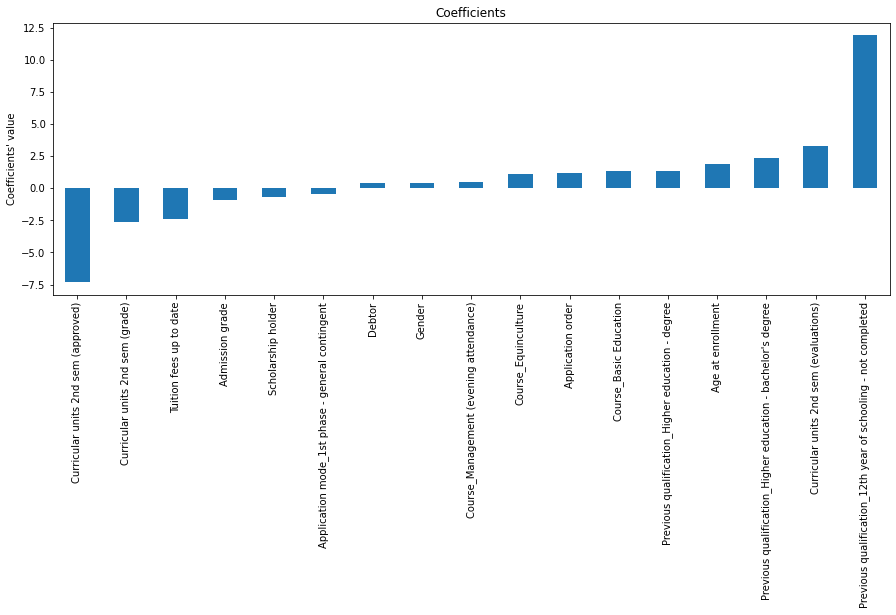

In [30]:
# Coefficients value

s = pd.Series(
    logit.coef_[0],
    index=logit.feature_names_in_,
)

s.sort_values().plot.bar(figsize=(15,5))
plt.ylabel("Coefficients' value")
plt.title("Coefficients")
plt.show()

The previous qualification being 12th year not completed seems to increase the probability of dropout a lot. This makes sense. If student's didn't complete their former studies, they are more likely to drop out of the university as well.

The number of curricular units approved in the last semester reduces the probability of dropout. This makes sense as well. If the student did well in the last semester, they will likely not drop out.

## Coefficient magnitude

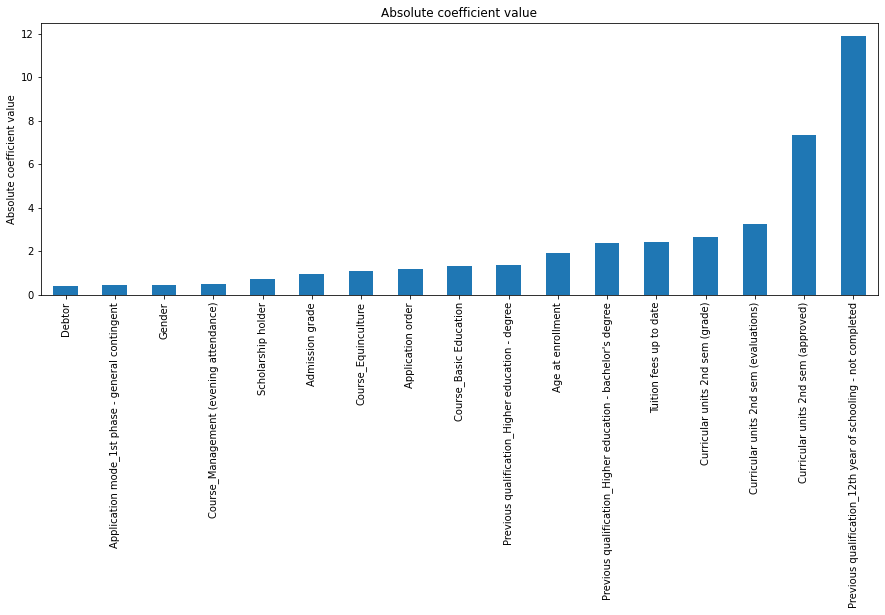

In [31]:
s = pd.Series(
    np.abs(logit.coef_[0]),
    index=logit.feature_names_in_,
)

s.sort_values().plot.bar(figsize=(15,5))
plt.ylabel("Absolute coefficient value")
plt.title("Absolute coefficient value")
plt.show()

The previous qualifications and the curricular units seem to be the most important features to predict dropout, albeit in opposite directions.

## Odds ratio

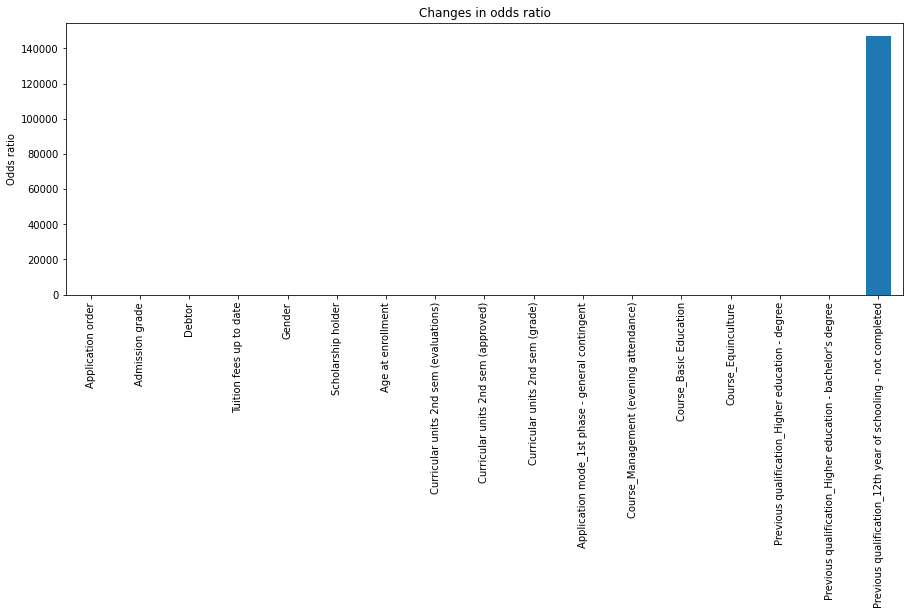

In [32]:
# Calculate and plot the odds ratio

s = pd.Series(
    np.exp(logit.coef_[0]),
    index=logit.feature_names_in_,
)

s.plot.bar(figsize=(15,5))
plt.ylabel("Odds ratio")
plt.title("Changes in odds ratio")
plt.show()

In [33]:
logit.coef_[0]

array([ 1.18292965, -0.94793474,  0.3973726 , -2.42371441,  0.43599083,
       -0.70315231,  1.9046822 ,  3.24171584, -7.32992836, -2.62908708,
       -0.43335631,  0.48213241,  1.32868492,  1.07916698,  1.36852033,
        2.35937336, 11.89916681])

The odds ratio is hard to visualize from the plot, because the coefficients are big, therefore the exponential of the coefficients are also big.

Basically, not having completed the 12th year of schooling increases the odds of dropout by a lot (about `np.exp(11.9)`.

On the contrary, having approved curricular units in the second semester reduces the dropout by a lot (about `np.exp(-7.9)`.

The last one is so small, that it's not obvious from the plot.

## Local explanations

Evaluate observations 525 and 3017 from the test set and draw some conclusions.

In [34]:
coeffs = logit.coef_[0]

In [35]:
obs = 525

In [36]:
# probability of dropout

logit.predict_proba(X_test.loc[obs].to_frame().T)

array([[0.41842696, 0.58157304]])

For this student there is almost a 50:50 chance of dropout. Let's see what are the key indicators.

In [37]:
X_test.loc[obs]

Application order                                                0.111111
Admission grade                                                  0.431579
Debtor                                                           0.000000
Tuition fees up to date                                          1.000000
Gender                                                           1.000000
Scholarship holder                                               0.000000
Age at enrollment                                                0.264151
Curricular units 2nd sem (evaluations)                           0.272727
Curricular units 2nd sem (approved)                              0.050000
Curricular units 2nd sem (grade)                                 0.592308
Application mode_1st phase - general contingent                  0.000000
Course_Management (evening attendance)                           0.000000
Course_Basic Education                                           0.000000
Course_Equinculture                   

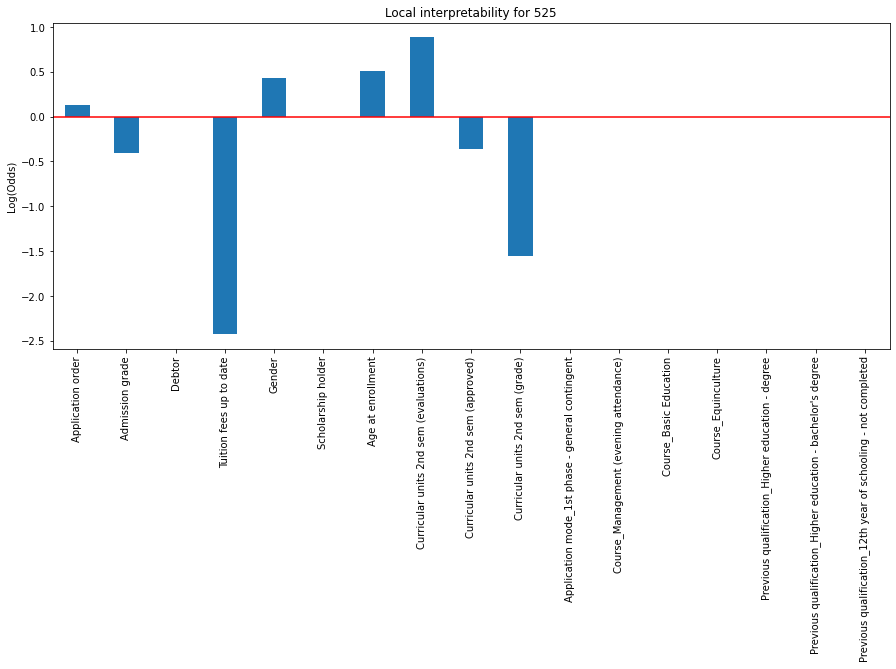

In [38]:
# log(Odds) contribution of each feature
effect = coeffs * X_test.loc[obs]

effect.plot.bar(figsize=(15,6))

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Log(Odds)")
plt.title(f"Local interpretability for {obs}")
plt.show()

For this person, the fact that they paid their tuition fees, suggests they will not dropout. Their grades are also indicative of not dropping out. Both reduce the probability.

The age at enrollment and gender increase their probability of dropout on the other hand.

In [39]:
obs = 3017

In [40]:
# probability of dropoutl

logit.predict_proba(X_test.loc[obs].to_frame().T)

array([[0.9801859, 0.0198141]])

These person has a tiny probability of dropping out. Let's explore why.

In [41]:
X_test.loc[obs]

Application order                                                0.111111
Admission grade                                                  0.250526
Debtor                                                           0.000000
Tuition fees up to date                                          1.000000
Gender                                                           0.000000
Scholarship holder                                               0.000000
Age at enrollment                                                0.018868
Curricular units 2nd sem (evaluations)                           0.272727
Curricular units 2nd sem (approved)                              0.400000
Curricular units 2nd sem (grade)                                 0.782564
Application mode_1st phase - general contingent                  1.000000
Course_Management (evening attendance)                           0.000000
Course_Basic Education                                           0.000000
Course_Equinculture                   

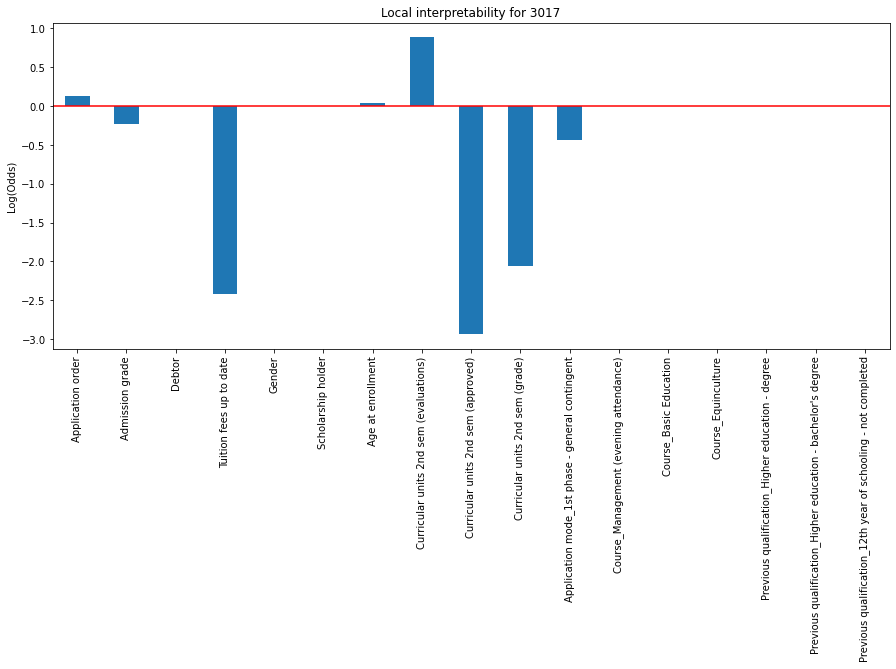

In [42]:
# log(Odds) contribution of each feature
effect = coeffs * X_test.loc[obs]

effect.plot.bar(figsize=(15,6))

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Log(Odds)")
plt.title(f"Local interpretability for {obs}")
plt.show()

This person has their tuition up to date, approved several units in the second semester and with good grades, all of which decrease the probability of dropout. 